In [2]:

from sklearn.model_selection import train_test_split
import pandas as pd
#set verbose to 0 so that it prints from the callback function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GlobalAveragePooling1D


In [3]:
#load data

print('Loading data...')

#4 datasets
#CYP1A2_fixpka.smi
#CYP2C19_substrate_fixpka.smi
#CYP2D6_fixpka.smi
#CYP3A4_fixpka.smi

datasetFile='CYP1A2_fixpka.smi'
dataset = pd.read_csv(datasetFile, sep= ' ', header=None)
X_SMILES, y = dataset.iloc[:,:-1], dataset.iloc[:, -1]

#Library of unique characters. The first element is not used for padding
char_lib=["ZMY"]

#Find characters of sequences and build a library
for index, SMILESsequence in X_SMILES.iterrows():
    for letter in SMILESsequence[0]:
        if not letter in char_lib:            
            char_lib.append(letter)

X=[]
#SMILES sequence to an array
for index, SMILESsequence in X_SMILES.iterrows():
    sequenceArray=[]
    for letter in SMILESsequence[0]:
        sequenceArray.append(char_lib.index(letter))
    X.append(sequenceArray)
    
print('data loaded')

Loading data...
data loaded


In [133]:
#add zeros
X=sequence.pad_sequences(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=428)

max_features = len(char_lib)
maxlen = X_train.shape[1]

In [5]:
print(X_train.shape)
print(max_features)
print(maxlen)

(11922, 226)
43
226


In [192]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import roc_curve, auc
class CustomCallbacks(Callback):
    def __init__(self, filename="best_weight.hdf5", monitor='val_acc', patience=10, test_input=None, test_label=None):
        super(Callback, self).__init__()
        self.filename = filename
        self.monitor = monitor
        self.patience = patience
        self.test_input=test_input
        self.test_label=test_label

        self.wait = 0
        
        if 'acc' in self.monitor or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.Inf
        self.losses = []
        self.acc = []
        self.val_acc =[]
        self.val_losses=[]             

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.val_losses.append(logs.get('val_loss'))  
        
        y_score=self.model.predict(X_test)
        y_score_get_value=[]
        for item in y_score:
            y_score_get_value.append(item[0])    
        fpr, tpr, _ = roc_curve(y_test, y_score_get_value)
        val_auc=auc(fpr,tpr)

        print("acc: %0.3f" % logs.get('acc'), 
              ", loss: %0.3f" % logs.get('loss'),
              ", val_acc: %0.3f" % logs.get('val_acc'),
              ", val_loss: %0.3f" % logs.get('val_loss'),
              ", val_auc: %0.3f" % val_auc)        
        
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
        else:
            if self.monitor_op(current, self.best):
                print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, self.monitor, self.best,
                                     current, self.filename))
                self.best = current                       
                self.wait = 0
                self.model.save(self.filename, overwrite=True)
            else:
                print('Epoch %05d: %s did not improve' %  (epoch, self.monitor))
                if self.wait >= self.patience:                   
                    self.model.stop_training = True
                self.wait += 1

    def on_train_end(self, logs=None):
        if self.wait >= self.patience:
            print('Warning: early stopping')
        self.wait=0
        if 'acc' in self.monitor or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.In
        
my_callbacks=CustomCallbacks(filename="CYP1A2_conv1.hdf5", monitor='val_acc', patience=np.Inf, test_input=X_test, test_label=y_test)


In [83]:
from keras.layers.pooling import MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.recurrent import LSTM 
from keras.layers import Flatten
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers.merge import Concatenate

In [195]:


inputs = Input(shape=(maxlen,))
embedding_1=Embedding(input_dim=max_features,output_dim=50, input_length=maxlen)(inputs)
dropout_1=Dropout(0.5)(embedding_1)

conv1d_kernel_size=[7,3,5]
conv1d_filters=[128,128,128]
my_globalmaxpoolings=[]
for i in range(0,len(conv1d_kernel_size)):
    conv1d_1=Conv1D(filters=conv1d_filters[i],
                    kernel_size=conv1d_kernel_size[i], 
                    padding='valid', 
                    strides=1)(dropout_1)
   
    leakyrelu_1=LeakyReLU(0.3)(conv1d_1) #better than relu with 0.004 more accuracy...
    dropout_conv=Dropout(0.5)(leakyrelu_1)
    globalmaxpooling1d_1=GlobalMaxPooling1D()(leakyrelu_1)
    my_globalmaxpoolings.append(globalmaxpooling1d_1)

concatenate_1=Concatenate()(my_globalmaxpoolings)
#model.add(MaxPooling1D(pool_size=2))

dense_1=Dense(500)(concatenate_1)
dropout_2=Dropout(0.5)(dense_1)
leakyrelu_hidden=LeakyReLU(0.3)(dropout_2)

dense2=Dense(1)(leakyrelu_hidden)
prediction=Activation('sigmoid')(dense2)


model = Model(inputs=inputs, outputs=prediction)
adam=optimizers.Adam(lr=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_33 (InputLayer)            (None, 226)           0                                            
____________________________________________________________________________________________________
embedding_63 (Embedding)         (None, 226, 50)       2150        input_33[0][0]                   
____________________________________________________________________________________________________
dropout_148 (Dropout)            (None, 226, 50)       0           embedding_63[0][0]               
____________________________________________________________________________________________________
conv1d_99 (Conv1D)               (None, 220, 128)      44928       dropout_148[0][0]                
___________________________________________________________________________________________

In [196]:
#data is not shuffled using validation_split. Have to use sk-learn to shuffle it first. 
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100,
          callbacks=[my_callbacks],
          validation_data=(X_test,y_test),
          verbose=0) 

acc: 0.687 , loss: 0.590 , val_acc: 0.733 , val_loss: 0.529 , val_auc: 0.816
Epoch 00000: val_acc improved from -inf to 0.73298, saving model to CYP1A2_conv1.hdf5
acc: 0.727 , loss: 0.536 , val_acc: 0.757 , val_loss: 0.512 , val_auc: 0.831
Epoch 00001: val_acc improved from 0.73298 to 0.75746, saving model to CYP1A2_conv1.hdf5
acc: 0.749 , loss: 0.514 , val_acc: 0.757 , val_loss: 0.497 , val_auc: 0.843
Epoch 00002: val_acc did not improve
acc: 0.762 , loss: 0.498 , val_acc: 0.761 , val_loss: 0.493 , val_auc: 0.847
Epoch 00003: val_acc improved from 0.75746 to 0.76115, saving model to CYP1A2_conv1.hdf5
acc: 0.764 , loss: 0.492 , val_acc: 0.741 , val_loss: 0.523 , val_auc: 0.856
Epoch 00004: val_acc did not improve
acc: 0.762 , loss: 0.494 , val_acc: 0.745 , val_loss: 0.518 , val_auc: 0.855
Epoch 00005: val_acc did not improve
acc: 0.773 , loss: 0.479 , val_acc: 0.783 , val_loss: 0.467 , val_auc: 0.860
Epoch 00006: val_acc improved from 0.76115 to 0.78296, saving model to CYP1A2_conv1.hd

acc: 0.849 , loss: 0.345 , val_acc: 0.777 , val_loss: 0.540 , val_auc: 0.885
Epoch 00066: val_acc did not improve
acc: 0.852 , loss: 0.339 , val_acc: 0.795 , val_loss: 0.474 , val_auc: 0.885
Epoch 00067: val_acc did not improve
acc: 0.848 , loss: 0.338 , val_acc: 0.817 , val_loss: 0.465 , val_auc: 0.886
Epoch 00068: val_acc improved from 0.81449 to 0.81718, saving model to CYP1A2_conv1.hdf5
acc: 0.852 , loss: 0.334 , val_acc: 0.800 , val_loss: 0.495 , val_auc: 0.887
Epoch 00069: val_acc did not improve
acc: 0.851 , loss: 0.337 , val_acc: 0.808 , val_loss: 0.467 , val_auc: 0.885
Epoch 00070: val_acc did not improve
acc: 0.855 , loss: 0.337 , val_acc: 0.801 , val_loss: 0.483 , val_auc: 0.886
Epoch 00071: val_acc did not improve
acc: 0.855 , loss: 0.334 , val_acc: 0.819 , val_loss: 0.464 , val_auc: 0.885
Epoch 00072: val_acc improved from 0.81718 to 0.81885, saving model to CYP1A2_conv1.hdf5
acc: 0.853 , loss: 0.334 , val_acc: 0.811 , val_loss: 0.472 , val_auc: 0.886
Epoch 00073: val_acc 

In [173]:
from keras import models
best_model=models.load_model("CYP1A2_conv1.hdf5")
#print(best_model.summary())


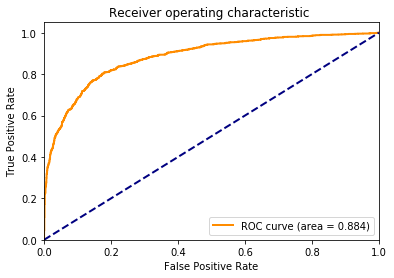

In [197]:
%matplotlib inline
import matplotlib.pyplot as plt

y_score=best_model.predict(X_test)
y_score_get_value=[]
for item in y_score:
    y_score_get_value.append(item[0])
    
fpr, tpr, _ = roc_curve(y_test, y_score_get_value)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.savefig("roc.svg", format="svg")
plt.show()


